<a href="https://colab.research.google.com/github/manujism/1F_Drawing_Simulations/blob/main/Monte_Carlo_Simulation_v06082025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# @title Agenda Of The Code

"""

This code is designed to see how Mr. Priyank Tandon’s investments might grow from age 30 to 55 using past market data and his quarterly income–expense details. We run 10,000 simulations for each of several investment mixes, including his current one, where his quarterly surplus is added to the portfolio and random past returns are applied to reflect market ups and downs. Along with these fixed strategies, we also run 5,000 optimisation tests on random portfolio combinations to find the mix that offers the best balance between return and risk. For each option, we measure average growth, best- and worst-case outcomes, and the chances of a decline in value. The results are shown through clear charts and summaries, making it easy to compare how each approach performs over time while accounting for market volatility.


"""

'\n\nThis code is designed to see how Mr. Priyank Tandon’s investments might grow from age 30 to 55 using past market data and his quarterly income–expense details. We run 10,000 simulations for each of several investment mixes, including his current one, where his quarterly surplus is added to the portfolio and random past returns are applied to reflect market ups and downs. Along with these fixed strategies, we also run 5,000 optimisation tests on random portfolio combinations to find the mix that offers the best balance between return and risk. For each option, we measure average growth, best- and worst-case outcomes, and the chances of a decline in value. The results are shown through clear charts and summaries, making it easy to compare how each approach performs over time while accounting for market volatility.\n\n\n'

In [ ]:
'''



In [57]:
# --- SECTION 1: SETUP & PARAMETERS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import io
import textwrap

sns.set(style="whitegrid")
print("Libraries imported successfully.")

# Simulation Parameters
initial_age = 30
end_age = 55
years_to_simulate = end_age - initial_age
initial_corpus = 11213714
num_simulations = 10_000
num_quarters = years_to_simulate * 4

# Asset Allocation Strategies (SIP mix for new investments)
asset_allocation_strategies = {
    "Client's Current Mix": {"Equity": 0.51, "Real Estate": 0.00, "Passive Income Assets": 0.00, "Debt": 0.36, "Alternative Investments": 0.13},
    "Conservative": {"Equity": 0.20, "Real Estate": 0.00, "Passive Income Assets": 0.00, "Debt": 0.60, "Alternative Investments": 0.20},
    "Neutral": {"Equity": 0.40, "Real Estate": 0.00, "Passive Income Assets": 0.00, "Debt": 0.40, "Alternative Investments": 0.20},
    "Aggressive": {"Equity": 0.60, "Real Estate": 0.00, "Passive Income Assets": 0.00, "Debt": 0.20, "Alternative Investments": 0.20},
    "Ultra Aggressive": {"Equity": 0.80, "Real Estate": 0.00, "Passive Income Assets": 0.00, "Debt": 0.10, "Alternative Investments": 0.10}
}

print("\nInitial parameters and asset allocation strategies defined.")
print(f"Client's Initial Age: {initial_age}")
print(f"Simulation End Age: {end_age}")
print(f"Initial Corpus: ₹{initial_corpus:,.2f}")
print(f"Number of Simulations per Strategy: {num_simulations}")
print(f"Number of Optimization Runs: {num_optimization_runs}")


Libraries imported successfully.

Initial parameters and asset allocation strategies defined.
Client's Initial Age: 30
Simulation End Age: 55
Initial Corpus: ₹11,213,714.00
Number of Simulations per Strategy: 10000
Number of Optimization Runs: 10000


In [58]:
# --- SECTION 2: DATA LOADING ---

# Asset Returns Data
try:
    try:
        asset_returns = pd.read_excel('Quarterly Returns for Each Asset.xlsx')
    except FileNotFoundError:
        print("\nCreating dummy 'Quarterly Returns for Each Asset.xlsx' for demonstration.")
        dummy_returns_data = {
            'Date': pd.date_range(start='2000-01-01', periods=100, freq='Q'),
            'Equity': np.random.normal(0.035, 0.09, 100),
            'Real Estate': np.random.normal(0.02, 0.05, 100),
            'Passive Income Assets': np.random.normal(0.018, 0.03, 100),
            'Debt': np.random.normal(0.015, 0.015, 100),
            'Alternative Investments': np.random.normal(0.028, 0.08, 100)
        }
        asset_returns = pd.DataFrame(dummy_returns_data)
        asset_returns.to_excel('Quarterly Returns for Each Asset.xlsx', index=False)

    if 'Date' in asset_returns.columns:
        asset_returns = asset_returns.drop(columns=['Date'])
    print("\nAsset returns data loaded successfully.")
    print("Available asset classes:", list(asset_returns.columns))
except Exception as e:
    print(f"\nError loading asset returns: {e}")
    asset_returns = pd.DataFrame()

# Income & Expense Data
try:
    try:
        income_expense_df = pd.read_excel('Quarterly Income & Expense Data.xlsx')
    except FileNotFoundError:
        print("Creating dummy 'Quarterly Income & Expense Data.xlsx' for demonstration.")
        dummy_financials_data = {
            'Age': np.repeat(range(initial_age, end_age + 1), 4)[:num_quarters],
            'Quarter': (['Q1', 'Q2', 'Q3', 'Q4'] * years_to_simulate)[:num_quarters],
            'Income': np.random.uniform(500000, 800000, num_quarters),
            'Total Expense': np.random.uniform(300000, 500000, num_quarters),
        }
        dummy_financials_data['End Total Surplus'] = dummy_financials_data['Income'] - dummy_financials_data['Total Expense']
        income_expense_df = pd.DataFrame(dummy_financials_data)
        income_expense_df.to_excel('Quarterly Income & Expense Data.xlsx', index=False)

    income_expense_df.columns = income_expense_df.columns.str.strip()
    income_expense_df = income_expense_df.rename(columns={
        'Income': 'Earning', 'Total Expense': 'Expense', 'End Total Surplus': 'Net_Cash_Flow'
    })

    quarterly_financials = income_expense_df.copy()
    quarterly_financials['Quarter_Num'] = quarterly_financials['Quarter'].map({'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4})
    quarterly_financials = quarterly_financials.sort_values(by=['Age', 'Quarter_Num']).reset_index(drop=True)

    print("\nIncome, expense, and investment data loaded successfully.")
except Exception as e:
    print(f"\nError loading income/expense data: {e}")
    quarterly_financials = pd.DataFrame()



Asset returns data loaded successfully.
Available asset classes: ['Equity', 'Real Estate', 'Passive Income Assets', 'Debt', 'Alternative Investments']

Income, expense, and investment data loaded successfully.


In [59]:
# --- SECTION 3: MONTE CARLO SIMULATION FUNCTION ---
def run_monte_carlo_simulation(initial_corpus_allocation, sip_allocation, returns_df, financials_df):
    final_corpus_values = []
    corpus_trajectories = []
    final_asset_breakdowns = []
    asset_classes = list(sip_allocation.keys())
    quarterly_cash_flows = financials_df['Net_Cash_Flow'].values

    for _ in range(num_simulations):
        asset_values = {a: initial_corpus * w for a, w in initial_corpus_allocation.items()}
        current_corpus = initial_corpus
        corpus_path = [current_corpus]

        for quarter_idx in range(min(len(quarterly_cash_flows), num_quarters)):
            net_cash_flow = quarterly_cash_flows[quarter_idx]
            if sum(asset_values.values()) + net_cash_flow > 0:
                for asset in asset_classes:
                    asset_values[asset] = asset_values.get(asset, 0) + net_cash_flow * sip_allocation[asset]
            else:
                asset_values = {a: 0 for a in asset_classes}

            sampled_returns = returns_df[asset_classes].sample(n=1).iloc[0]
            for asset in asset_classes:
                asset_values[asset] *= (1 + sampled_returns[asset])

            current_corpus = max(sum(asset_values.values()), 0)
            corpus_path.append(current_corpus)

        final_corpus_values.append(current_corpus)
        corpus_trajectories.append(corpus_path)
        final_asset_breakdowns.append(asset_values)

    avg_breakdown_df = pd.DataFrame(final_asset_breakdowns).mean().to_dict()
    return np.array(final_corpus_values), np.array(corpus_trajectories), avg_breakdown_df


In [60]:
# --- SECTION 4: RUN SIMULATIONS FOR ALL STRATEGIES ---
simulation_results = {}
trajectories_results = {}
asset_breakdown_results = {}

if not asset_returns.empty and not quarterly_financials.empty:
    print("\nRunning simulations for all pre-defined strategies...")
    initial_corpus_mix = asset_allocation_strategies["Client's Current Mix"]

    for strategy_name, sip_mix in asset_allocation_strategies.items():
        print(f"   - Running: {strategy_name}")
        final_dist, trajectories, avg_breakdown = run_monte_carlo_simulation(
            initial_corpus_allocation=initial_corpus_mix,
            sip_allocation=sip_mix,
            returns_df=asset_returns,
            financials_df=quarterly_financials
        )
        simulation_results[strategy_name] = final_dist
        trajectories_results[strategy_name] = trajectories
        asset_breakdown_results[strategy_name] = avg_breakdown
else:
    print("\nSkipping simulation due to missing data.")



Running simulations for all pre-defined strategies...
   - Running: Client's Current Mix
   - Running: Conservative
   - Running: Neutral
   - Running: Aggressive
   - Running: Ultra Aggressive


In [61]:
# --- SECTION 5: ANALYSIS & SUMMARY ---
if simulation_results:
    analysis_summary = []
    for strategy_name, results in simulation_results.items():
        mean_val = np.mean(results)
        std_dev = np.std(results)
        downside_returns = results[results < mean_val]
        downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0

        analysis_summary.append({
            "Strategy": strategy_name,
            "Mean (INR)": mean_val, "Median (INR)": np.median(results), "Std Dev (INR)": std_dev,
            "5th Pctl (INR)": np.percentile(results, 5), "95th Pctl (INR)": np.percentile(results, 95),
            "Prob < Start (%)": np.mean(results < initial_corpus) * 100,
            "Sharpe Ratio": (mean_val - initial_corpus) / (std_dev + 1e-9),
            "Sortino Ratio": (mean_val - initial_corpus) / (downside_std_dev + 1e-9)
        })

    summary_df = pd.DataFrame(analysis_summary)
    for col in ["Mean (INR)", "Median (INR)", "5th Pctl (INR)", "95th Pctl (INR)", "Std Dev (INR)"]:
        summary_df[col] = summary_df[col] / 1e7
    summary_df.rename(columns=lambda x: x.replace("(INR)", "(Cr)"), inplace=True)
    summary_df = summary_df.sort_values(by="Sharpe Ratio", ascending=False)

    print("\n" + "="*130)
    print(" " * 40 + "SIMULATION ANALYSIS (PRE-DEFINED STRATEGIES)")
    print("="*130)
    print(summary_df.to_string(formatters={
        "Mean (Cr)": "₹{:,.2f}".format, "Median (Cr)": "₹{:,.2f}".format,
        "5th Pctl (Cr)": "₹{:,.2f}".format, "95th Pctl (Cr)": "₹{:,.2f}".format,
        "Std Dev (Cr)": "₹{:,.2f}".format, "Prob < Start (%)": "{:,.2f}%".format,
        "Sharpe Ratio": "{:,.2f}".format, "Sortino Ratio": "{:,.2f}".format
    }, index=False))
    print("="*130 + "\n")



                                        SIMULATION ANALYSIS (PRE-DEFINED STRATEGIES)
            Strategy Mean (Cr) Median (Cr) Std Dev (Cr) 5th Pctl (Cr) 95th Pctl (Cr) Prob < Start (%) Sharpe Ratio Sortino Ratio
        Conservative    ₹18.54      ₹16.06        ₹9.54        ₹10.03         ₹35.70            0.00%         1.83          6.79
             Neutral    ₹19.57      ₹16.56       ₹11.01         ₹9.64         ₹39.61            0.00%         1.68          6.21
          Aggressive    ₹20.28      ₹16.92       ₹12.24         ₹9.14         ₹42.91            0.00%         1.57          5.71
Client's Current Mix    ₹19.85      ₹16.52       ₹12.13         ₹9.30         ₹40.80            0.00%         1.54          5.94
    Ultra Aggressive    ₹20.91      ₹16.81       ₹14.12         ₹8.52         ₹46.54            0.00%         1.40          5.40



In [62]:
# --- SECTION 6: NET WORTH BREAKDOWN ---
if asset_breakdown_results:
    print("\n" + "="*130)
    print(" " * 45 + "NET WORTH BREAKDOWN BY ASSET AND AGE")
    print("="*130)

    initial_corpus_mix = asset_allocation_strategies["Client's Current Mix"]
    initial_breakdown = {a: initial_corpus * w for a, w in initial_corpus_mix.items()}

    print(f"\n--- At Age {initial_age} (Start) ---")
    for asset, value in initial_breakdown.items():
        print(f"    {asset:<25}: ₹{value:,.2f}")
    print(f"{'-'*50}\n    {'Total Net Worth':<25}: ₹{initial_corpus:,.2f}")
    print("="*130)

    for strategy_name, final_breakdown in asset_breakdown_results.items():
        print(f"\n--- At Age {end_age} (End) for '{strategy_name}' Strategy ---")
        total_final_networth = sum(final_breakdown.values())
        for asset in sorted(set(initial_breakdown.keys()) | set(final_breakdown.keys())):
            print(f"    {asset:<25}: ₹{final_breakdown.get(asset, 0):,.2f}")
        print(f"{'-'*50}\n    {'Average Total Net Worth':<25}: ₹{total_final_networth:,.2f}")
        print("-"*130)



                                             NET WORTH BREAKDOWN BY ASSET AND AGE

--- At Age 30 (Start) ---
    Equity                   : ₹5,718,994.14
    Real Estate              : ₹0.00
    Passive Income Assets    : ₹0.00
    Debt                     : ₹4,036,937.04
    Alternative Investments  : ₹1,457,782.82
--------------------------------------------------
    Total Net Worth          : ₹11,213,714.00

--- At Age 55 (End) for 'Client's Current Mix' Strategy ---
    Alternative Investments  : ₹30,289,434.92
    Debt                     : ₹43,197,999.76
    Equity                   : ₹125,043,767.46
    Passive Income Assets    : ₹0.00
    Real Estate              : ₹0.00
--------------------------------------------------
    Average Total Net Worth  : ₹198,531,202.13
----------------------------------------------------------------------------------------------------------------------------------

--- At Age 55 (End) for 'Conservative' Strategy ---
    Alternative Investments 

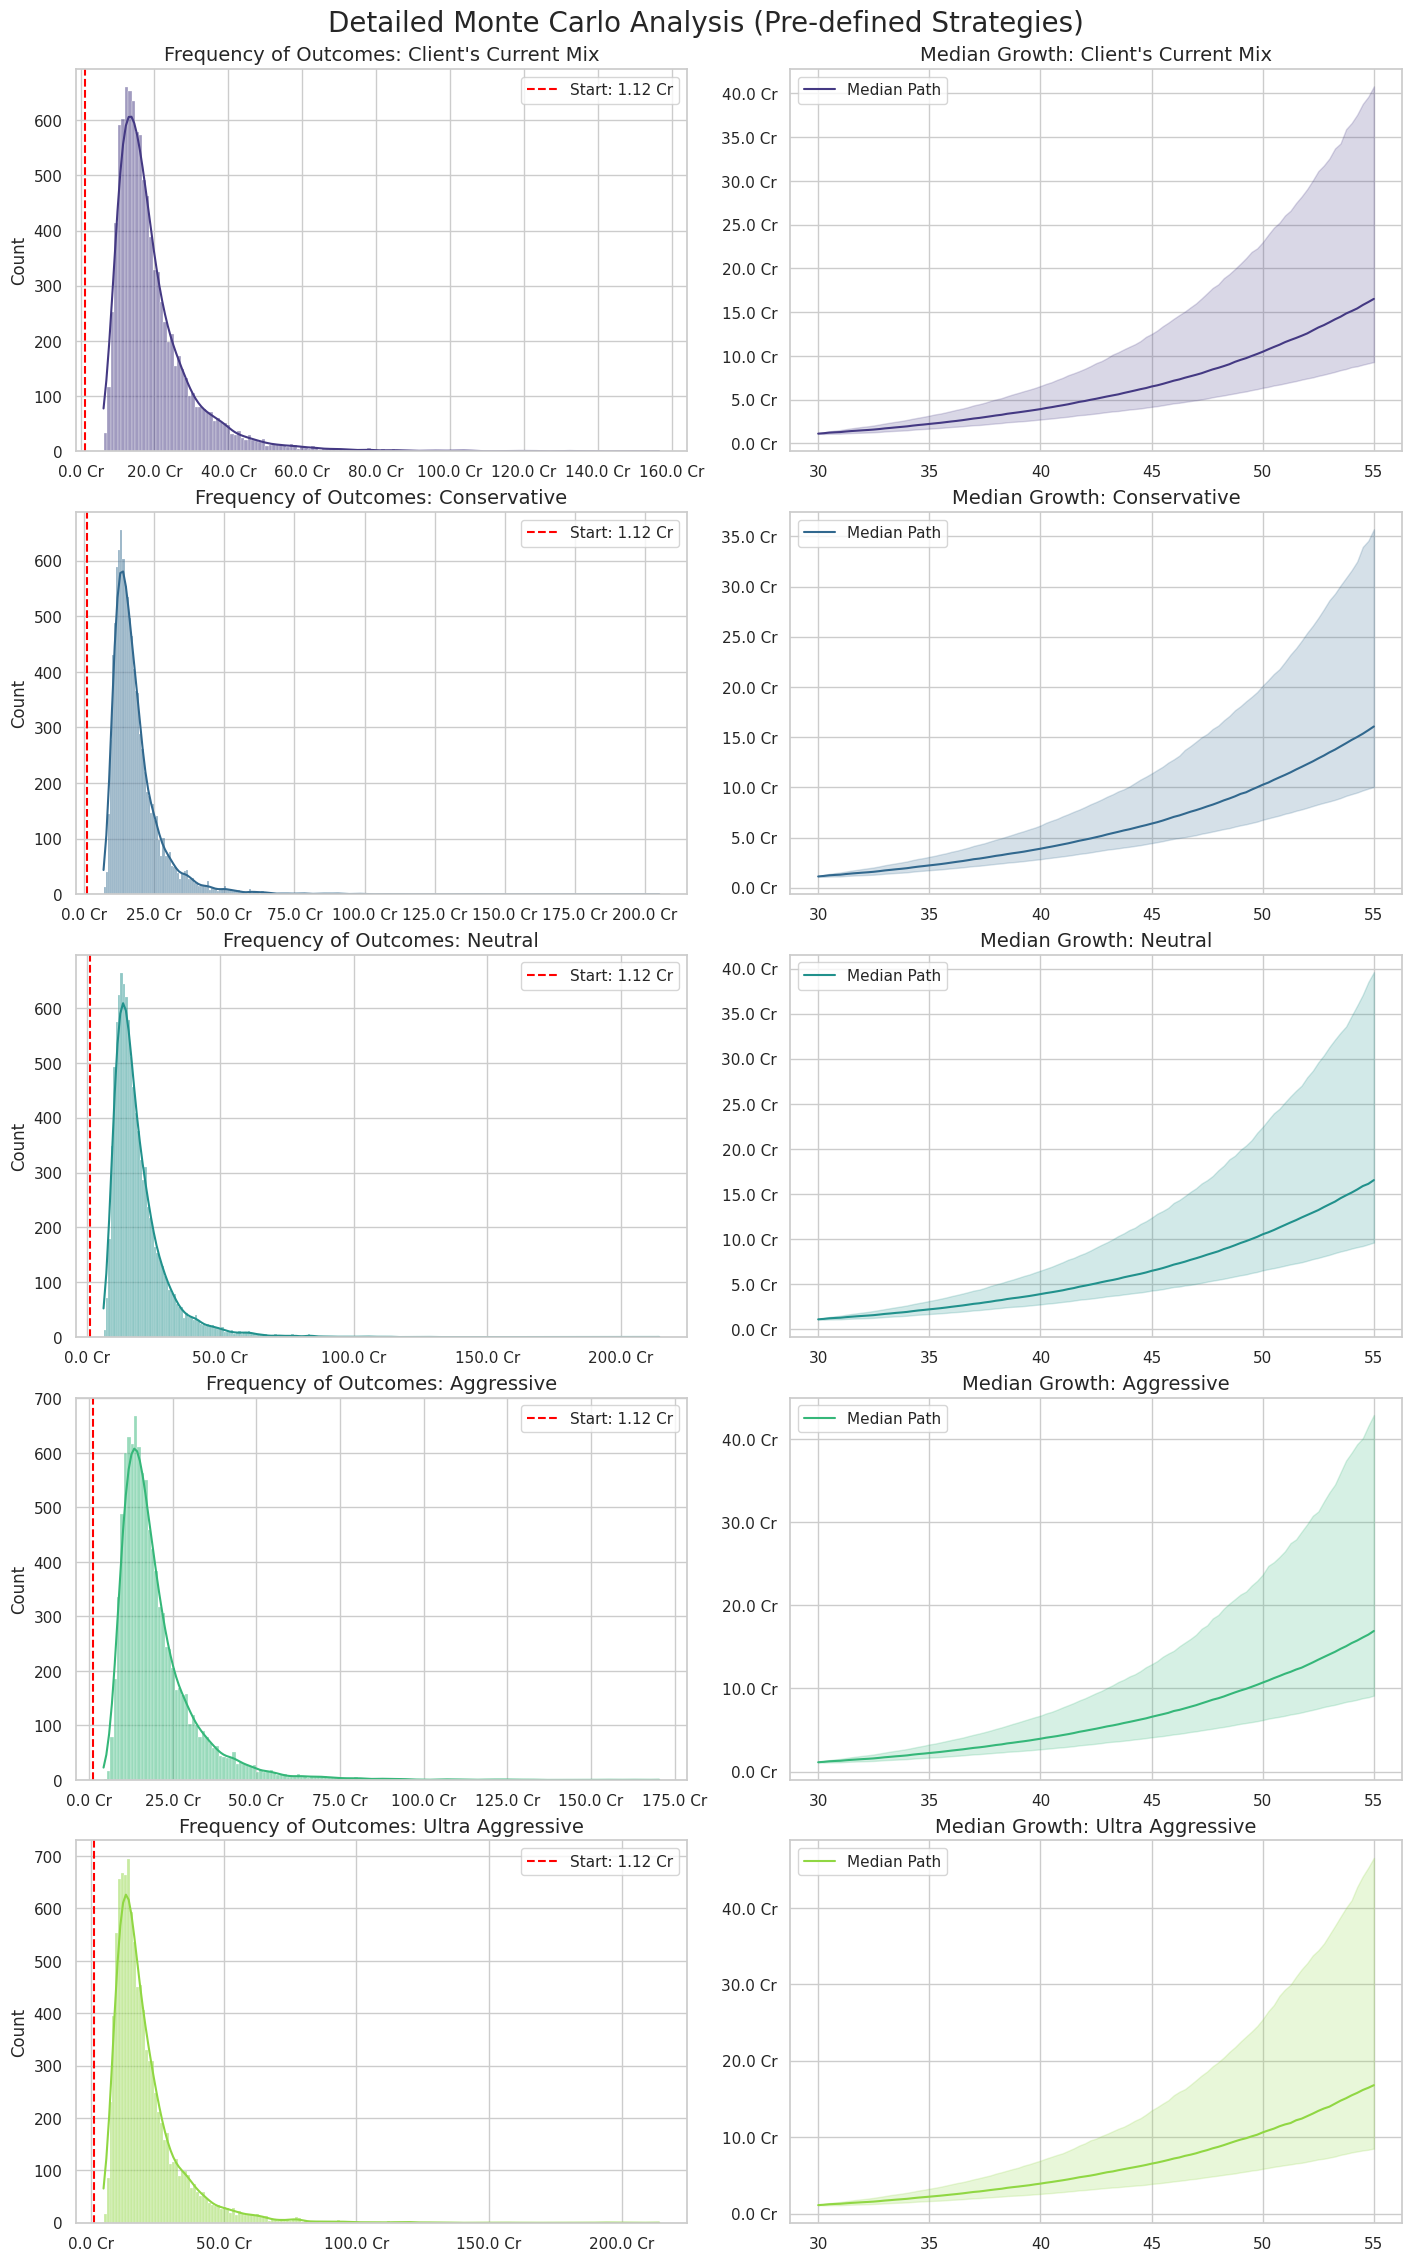

In [63]:
# --- SECTION 7: VISUALIZATION ---
if simulation_results:
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.titlesize': 14})

    def format_crore(x, pos): return f'{x/1e7:.1f} Cr'
    crore_formatter = mticker.FuncFormatter(format_crore)

    strategy_names = list(simulation_results.keys())
    fig, axs = plt.subplots(len(strategy_names), 2, figsize=(14, 4.5 * len(strategy_names)), constrained_layout=True)
    if len(strategy_names) == 1: axs = np.array([axs])

    for i, strategy in enumerate(strategy_names):
        color = sns.color_palette("viridis", len(strategy_names))[i]
        results = simulation_results[strategy]

        ax_hist = axs[i, 0]
        sns.histplot(results, ax=ax_hist, color=color, kde=True)
        ax_hist.axvline(initial_corpus, color='red', linestyle='--', label=f'Start: {initial_corpus/1e7:.2f} Cr')
        ax_hist.xaxis.set_major_formatter(crore_formatter)
        ax_hist.set_title(f"Frequency of Outcomes: {strategy}")
        ax_hist.legend()

        ax_growth = axs[i, 1]
        if trajectories_results:
            age_axis = np.linspace(initial_age, end_age, len(trajectories_results[strategy][0]))
            paths = np.array(trajectories_results[strategy])
            median, p5, p95 = np.median(paths, axis=0), np.percentile(paths, 5, axis=0), np.percentile(paths, 95, axis=0)
            ax_growth.plot(age_axis, median, color=color, label='Median Path')
            ax_growth.fill_between(age_axis, p5, p95, color=color, alpha=0.2)
            ax_growth.yaxis.set_major_formatter(crore_formatter)
            ax_growth.set_title(f"Median Growth: {strategy}")
            ax_growth.legend()

    fig.suptitle("Detailed Monte Carlo Analysis (Pre-defined Strategies)", fontsize=20)
    plt.show()
